# Mislabeled data detection - RoBERTa-MRPC

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **mislabeled data detection** tasks.

- Model: Robert-large (https://arxiv.org/abs/1907.11692; pretrained with publicly available datasets including BOOKCORPUS, WIKIPEDIA, and CC-NEWS)
- Fine-tuning dataset: GLUE-mrpc
    - What is MRPC? The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

References
- https://github.com/huggingface/peft/blob/main/examples/sequence_classification/LoRA.ipynb
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [6]:
from modelscope.msdatasets import MsDataset
# # Load the cola dataset
# train_datasets = MsDataset.load('glue', subset_name='cola', split='train')
# eval_datasets = MsDataset.load('glue', subset_name='cola', split='validation')

MsDataset.load(
            "glue",
            'qnli',
            cache_dir=None,
            use_auth_token=None,
        )

ConnectTimeout: HTTPSConnectionPool(host='www.modelscope.cn', port=443): Max retries exceeded with url: /api/v1/datasets/qnli/glue (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7ff092ca1010>, 'Connection to www.modelscope.cn timed out. (connect timeout=60)'))

In [1]:
import sys
sys.path.append('../src')
# from dataloader import create_dataloaders
from dataloader_ER import create_dataloaders
# from lora_model import LORAEngine,LORAEngineDeberta,LORAEngineDebertaMultiClass
from lora_model_vmap import LORAEngineDebertaMultiClass

# from influence import IFEngine
from influence_hyperinf import IFEngine

import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Set up hyperparameters and LoRA models

In [2]:
# model_name_or_path="roberta-large"
# model_name_or_path="/home/yanmy/roberta-base"
model_name_or_path="../../model/deberta-v3-base"
# model_name_or_path="../../model/roberta-large"
# task="mrpc"
task = "ER"
noise_ratio=0
batch_size=32
# target_modules=["query_proj", "key_proj", "value_proj"] ## deberta, for roberta, use ["value"]
# target_modules = ['value']
target_modules=["value_proj"] ## deberta, for roberta, use ["value"]

device="cuda:3"
num_epochs=4
lr=3e-3

In [ ]:
# fine-tuning models
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)
train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs

# lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
#                             target_modules=target_modules,
#                             train_dataloader=train_dataloader,
#                             eval_dataloader=eval_dataloader,
#                             device=device,
#                             num_epochs=num_epochs,
#                             lr=lr,
#                             low_rank=8, 
#                             task=task)

lora_engine = LORAEngineDeberta(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

## Fine-tune a model

In [3]:
# fine-tuning models
# dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
#                                            task=task,
#                                            noise_ratio=noise_ratio,
#                                            batch_size=batch_size,
#                                            train_file = '../ER/semi-text-c-FUSER/train.json',
#                                            valid_file = '../ER/semi-text-c-FUSER/valid.json',
#                                            test_file = '../ER/semi-text-c-FUSER/test.json')


dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size,
                                           train_file = '../ER/semi-text-c/train.json',
                                           valid_file = '../ER/semi-text-c/valid.json',
                                           test_file = '../ER/semi-text-c/test.json',
                                           max_length=256)
# train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs
train_dataloader, eval_dataloader,test_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs


# lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
#                             target_modules=target_modules,
#                             train_dataloader=train_dataloader,
#                             eval_dataloader=eval_dataloader,
#                             device=device,
#                             num_epochs=num_epochs,
#                             lr=lr,
#                             low_rank=8, 
#                             task=task)

lora_engine = LORAEngineDebertaMultiClass(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            # eval_dataloader=eval_dataloader,
                            eval_dataloader=eval_dataloader,
                            test_dataloader = test_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=16, 
                            task=task,
                            save_path = '../models/ER',
                            valid_each_epoch=False)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Map:   0%|          | 0/4179 [00:00<?, ? examples/s]

In [4]:
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ../../model/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,450 || all params: 184,720,132 || trainable%: 0.1605
Total Steps:564


100%|██████████| 141/141 [00:16<00:00,  8.66it/s]


Epoch 1: Training Loss = 0.505478358437829


100%|██████████| 141/141 [00:15<00:00,  8.97it/s]


Epoch 2: Training Loss = 0.19228826483037878


100%|██████████| 141/141 [00:15<00:00,  8.97it/s]


Epoch 3: Training Loss = 0.14015114000925782


100%|██████████| 141/141 [00:15<00:00,  8.97it/s]


Epoch 4: Training Loss = 0.1141124431717586


100%|██████████| 131/131 [00:19<00:00,  6.61it/s]

Prediction Result on Test Data: {'f1': 0.8093841642228738}


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).

In [5]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn, batch_size=32)

  0%|          | 0/141 [00:00<?, ?it/s]


ValueError: vmap(single_sample_grad, in_dims=(None, None, None, 0, 0, 0), ...)(<inputs>): Got in_dim=0 for an input but the input is of type <class 'str'>. We cannot vmap over non-Tensor arguments, please use None as the respective in_dim

In [15]:
from time import time
from tqdm.notebook import tqdm
import sys
from collections import defaultdict
import pandas as pd
import pickle, os
import torch
import numpy as np
class IFEngine(object):
        # 初始化存储时间、Hessian-Vector Product (HVP) 结果和影响函数（Influence Function）值的字典

    def __init__(self):
        self.time_dict=defaultdict(list)
        self.hvp_dict=defaultdict(list)
        self.IF_dict=defaultdict(list)

    def preprocess_gradients(self, tr_grad_dict, val_grad_dict, noise_index=None): # 存储训练集和验证集的梯度字典，并计算验证集平均梯度
        self.tr_grad_dict = tr_grad_dict # 训练集梯度字典
        self.val_grad_dict = val_grad_dict # 验证集梯度字典
        self.noise_index = noise_index # 可选的噪声索引（用于异常值处理）
        # 存储训练集和验证集的样本数
        self.n_train = len(self.tr_grad_dict.keys())
        self.n_val = len(self.val_grad_dict.keys())
        self.compute_val_grad_avg() # 计算验证集平均梯度

    def compute_val_grad_avg(self):
        # Compute the avg gradient on the validation dataset
        self.val_grad_avg_dict={}
        for weight_name in self.val_grad_dict[0]:
            # 初始化为与梯度同设备的零向量
            self.val_grad_avg_dict[weight_name]=torch.zeros(self.val_grad_dict[0][weight_name].shape).to(self.val_grad_dict[0][weight_name].device)
            # 逐个样本累加梯度并取平均值
            for val_id in self.val_grad_dict:
                self.val_grad_avg_dict[weight_name] += self.val_grad_dict[val_id][weight_name] / self.n_val

    def compute_hvps(self, lambda_const_param=10, compute_accurate=True, compute_LiSSA=True):
        '''
        Compute the influence function score under each method
        '''
        self.compute_hvp_iterative(lambda_const_param=lambda_const_param) ## HyperInf,使用 Schulz 迭代法计算 HVP 和近似 Hessian 逆矩阵
        self.compute_hvp_identity() ## Baseline TracIn
        self.compute_hvp_proposed(lambda_const_param=lambda_const_param) ## Datainf
        if compute_LiSSA:
            self.compute_hvp_LiSSA(lambda_const_param=lambda_const_param)
        if compute_accurate:
            self.compute_hvp_accurate(lambda_const_param=lambda_const_param)

    def compute_hvp_identity(self):
        '''
        TracIN
        '''
        start_time = time()
        self.hvp_dict['identity'] = self.val_grad_avg_dict.copy()
        self.time_dict['identity'] = time()-start_time
        print("Time taken for Hessian-free: ", self.time_dict['identity'])

    def compute_hvp_iterative(self, lambda_const_param=10, n_iteration=30):
        '''
        Compute the influence funcion score by our method HyperINF
        '''

        def schulz_inverse_stable(A, damping_factor=0, max_iterations=20, tol=1e-6):
            n = A.shape[0]
            #I = np.eye(n)
            I = torch.eye(n, device=A.device)
            A_damped = A + damping_factor * I  # Apply damping for stable

            #X = np.eye(n) * 0.00005  # Initial estimate of inverse matrix
            X = torch.eye(n, device=A.device) * 0.00005  # Initial estimate of inverse matrix

            for _ in range(max_iterations):
                # 通过 Schulz 方法更新逆矩阵估计值
                #X = X.dot(2 * I - A_damped.dot(X))
                X = X @ (2 * I - A_damped @ X)

                # # Check for convergence
                # if np.linalg.norm(I - A.dot(X)) < tol:
                #     break

            return X

        start_time = time()
        hvp_iterative_dict={}

        for _, weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation = 0.1 x (n * d_l)^(-1) \sum_{i=1}^{n} ||grad_i^l||_2^2, 计算 λ（正则化系数）：基于梯度的方差
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # iterative hvp computation
            # G_l: same shape of self.tr_grad_dict[0][weight_name].T @ self.tr_grad_dict[0][weight_name]
            # 构造 Fisher 信息矩阵（近似 Hessian）
            G_l = torch.zeros((self.tr_grad_dict[0][weight_name].T @ self.tr_grad_dict[0][weight_name]).shape).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device) # (grad_i^l)^T
                G_l += tmp_grad.T @ tmp_grad / self.n_train
                
            # 加入正则化项以保证矩阵可逆
            G_l = G_l + lambda_const * torch.eye(G_l.shape[0], device=G_l.device)
           # G_l = G_l.cpu().detach().numpy()
           # 使用 Schulz 方法近似计算逆矩阵
            # G_l_inv = schulz_inverse_stable(G_l, damping_factor=0.001, max_iterations=n_iteration, tol=1e-6)
            G_l_inv = torch.inverse(G_l)
            print(G_l.shape,G_l_inv.shape)
            # 计算 HVP: G_l_inv @ val_grad_avg
            hvp_iterative_dict[weight_name] = torch.tensor(self.val_grad_avg_dict[weight_name] @ G_l_inv)
            #print(hvp_iterative_dict[weight_name])
        self.hvp_dict['iterative'] = hvp_iterative_dict
        self.time_dict['iterative'] = time()-start_time
        print("Time taken for HyperINF: ", self.time_dict['iterative'])



    def compute_hvp_proposed(self, lambda_const_param=10):
        '''
        DataInf method
        '''
        start_time = time()
        hvp_proposed_dict={}

        for _ , weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation = 0.1 x (n * d_l)^(-1) \sum_{i=1}^{n} ||grad_i^l||_2^2
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation
            hvp=torch.zeros(self.val_grad_avg_dict[weight_name].shape).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict: # i
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device) # grad_i^l
                # L_(l,i) / (lambda + ||grad_i^l||_2^2) in Eqn. (5)
                C_tmp = torch.sum(self.val_grad_avg_dict[weight_name] * tmp_grad) / (lambda_const + torch.sum(tmp_grad**2)).to(self.val_grad_avg_dict[weight_name].device)
                # (v_l^T - C_tmp * (grad_i^l)^T ) / (n * lambda) in Eqn. (5)
                hvp += (self.val_grad_avg_dict[weight_name] - C_tmp*tmp_grad) / (self.n_train*lambda_const)
            hvp_proposed_dict[weight_name] = hvp
        self.hvp_dict['proposed'] = hvp_proposed_dict
        self.time_dict['proposed'] = time()-start_time
        print("Time taken for Datainf: ", self.time_dict['proposed'])

    def compute_hvp_accurate(self, lambda_const_param=10):
        start_time = time()
        hvp_accurate_dict={}
        for _ , weight_name in enumerate(tqdm(self.val_grad_avg_dict)):

            # lambda_const computation
            S=torch.zeros(len(self.tr_grad_dict.keys()))
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation (eigenvalue decomposition)
            AAt_matrix = torch.zeros(torch.outer(self.tr_grad_dict[0][weight_name].reshape(-1),
                                                 self.tr_grad_dict[0][weight_name].reshape(-1)).shape)
            for tr_id in self.tr_grad_dict:

                tmp_mat = torch.outer(self.tr_grad_dict[tr_id][weight_name].reshape(-1),
                                      self.tr_grad_dict[tr_id][weight_name].reshape(-1))
                AAt_matrix += tmp_mat


            L, V = torch.linalg.eig(AAt_matrix)
            L, V = L.float(), V.float()
            hvp = self.val_grad_avg_dict[weight_name].reshape(-1) @ V
            hvp = (hvp / (lambda_const + L/ self.n_train)) @ V.T

            hvp_accurate_dict[weight_name] = hvp.reshape(len(self.tr_grad_dict[0][weight_name]), -1)
            del tmp_mat, AAt_matrix, V # to save memory
        self.hvp_dict['accurate'] = hvp_accurate_dict
        self.time_dict['accurate'] = time()-start_time
        print("Time taken for Accurate: ", self.time_dict['accurate'])

    def compute_hvp_LiSSA(self, lambda_const_param=10, n_iteration=10, alpha_const=1.):
        '''
        LiSSA method
        '''
        start_time = time()
        hvp_LiSSA_dict={}

        for _, weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation
            running_hvp=self.val_grad_avg_dict[weight_name]
            for _ in range(n_iteration):
                hvp_tmp=torch.zeros(self.val_grad_avg_dict[weight_name].shape).to(self.val_grad_avg_dict[weight_name].device)
                for tr_id in self.tr_grad_dict:
                    tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                    hvp_tmp += (torch.sum(tmp_grad*running_hvp)*tmp_grad - lambda_const*running_hvp) / self.n_train

                running_hvp = self.val_grad_avg_dict[weight_name] + running_hvp - alpha_const*hvp_tmp
            hvp_LiSSA_dict[weight_name] = running_hvp

        self.hvp_dict['LiSSA'] = hvp_LiSSA_dict
        self.time_dict['LiSSA'] = time()-start_time
        print("Time taken for LiSSA: ", self.time_dict['LiSSA'])

    def compute_IF(self):
        for method_name in self.hvp_dict:
            if_tmp_dict = {}
            for tr_id in self.tr_grad_dict:
                if_tmp_value = 0
                for weight_name in self.val_grad_avg_dict:
                    if_tmp_value += torch.sum(self.hvp_dict[method_name][weight_name]*self.tr_grad_dict[tr_id][weight_name])
                if_tmp_dict[tr_id]= -if_tmp_value.cpu()
               # print(-if_tmp_value)

            self.IF_dict[method_name] = pd.Series(if_tmp_dict, dtype=float).to_numpy()


In [17]:
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)

influence_engine.compute_hvps(compute_accurate=False,compute_LiSSA=False)
influence_engine.compute_IF()

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size(

  0%|          | 0/25 [00:00<?, ?it/s]

Time taken for Datainf:  15.164361238479614


In [22]:
influence_engine.IF_dict['proposed']

array([ 146.31735229, 1650.41796875,  180.49357605, ...,  285.13562012,
          5.19919968,  148.25637817])

In [21]:
# result = torch.load('/home/yanmy/HyperINF-main/output/output_fp16_deberta_ER_v_proj.pkl')
result['proposed']

array([ 146.31735229, 1650.41796875,  180.49357605, ...,  285.13562012,
          5.19919968,  148.25637817])

In [8]:
from tqdm.notebook import tqdm
IF_device = 'cuda:3' ## 避免爆显存
for key in tqdm(tr_grad_dict): ## 尝试转为fp16计算
    for kk in tr_grad_dict[key]:
        tr_grad_dict[key][kk] = tr_grad_dict[key][kk].to(IF_device)
for key in tqdm(val_grad_dict):
    for kk in val_grad_dict[key]:
        val_grad_dict[key][kk] = val_grad_dict[key][kk].to(IF_device)

influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)

influence_engine.compute_hvps(compute_accurate=False,compute_LiSSA=True)
influence_engine.compute_IF()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size(

  0%|          | 0/25 [00:00<?, ?it/s]

Time taken for Datainf:  15.23117733001709


  0%|          | 0/25 [00:00<?, ?it/s]

Time taken for LiSSA:  75.86726307868958


In [23]:
torch.save(influence_engine.IF_dict,'../../HyperINF-main/output/output_fp16_deberta_ER_v_proj_inv.pkl')

In [ ]:
from influence_hyperinf import IFEngine
from tqdm.notebook import tqdm
IF_device = 'cuda:2' ## 避免爆显存
# tr_grad_dict_IF = tr_grad_dict.copy()
# val_grad_dict_IF = val_grad_dict.copy()
# ## to cuda
for key in tqdm(tr_grad_dict): ## 尝试转为fp16计算
    for kk in tr_grad_dict[key]:
        tr_grad_dict[key][kk] = tr_grad_dict[key][kk].to(IF_device)

for key in tqdm(val_grad_dict):
    for kk in val_grad_dict[key]:
        val_grad_dict[key][kk] = val_grad_dict[key][kk].to(IF_device)


## compute influence function
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)

influence_engine.compute_hvps(compute_accurate=False,compute_LiSSA=True)
influence_engine.compute_IF()

## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one case use `time_dict`.

`IF_dict` includes all the computed influence function values. Here, `identity` indicates the `Hessian-free` influence computation method. 

In [1]:
# -*- encoding:utf-8 -*-
import torch
import numpy as np
import transformers
print(torch.__version__)  # 1.7.1
print(transformers.__version__) # 2.1.1

1.13.1+cu117
4.46.3


In [3]:
from transformers import (
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    BitsAndBytesConfig,
    LlamaForCausalLM,
    LlamaTokenizer,
    DebertaV2ForSequenceClassification, DebertaV2Tokenizer, AdamW, get_linear_schedule_with_warmup,AutoTokenizer
)
tokenizer = AutoTokenizer.from_pretrained('/home/yanmy/model/deberta-v3-base/')

/home/yanmy/anaconda3/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [1]:
import torch
torch.save(influence_engine.IF_dict,'../../HyperINF-main/output/output_fp16_deberta_all.pkl')

NameError: name 'influence_engine' is not defined

In [13]:
influence_engine.IF_dict['identity']

array([ 0.00820148,  0.00500778,  0.00903799, ..., -0.02732378,
        0.06782677,  0.20921639])

## retrain

In [36]:
import torch
import numpy as np
result = torch.load('/home/yanmy/HyperINF-main/output/output_fp16_deberta.pkl')
index = np.argsort(result['proposed'])[500:1000]

In [31]:
import pandas as pd
pd.read_json('../ER/semi-text-c/train.json').iloc[index,-1].value_counts()

1    261
0    239
Name: 2, dtype: int64

In [26]:
a = np.argsort(result['proposed'])[:1000]

In [27]:
result = torch.load('/home/yanmy/HyperINF-main/output/output_deberta_fp16_ER.pkl')
b = np.argsort(result['proposed'])[:1000]

In [28]:
len(set(a).intersection(set(b)))

151

In [24]:
import torch
import numpy as np
result = torch.load('/home/yanmy/HyperINF-main/output/output_fp16_deberta_ER_v_proj_inv.pkl')
index = np.argsort(result['iterative'])[:1500]
import pandas as pd
pd.read_json('../ER/semi-text-c/train.json').iloc[index,-1].value_counts()

1    1073
0     427
Name: 2, dtype: int64

In [26]:
model_name_or_path="/home/yanmy/model/deberta-v3-base" 
# task="mrpc"
task = "ER"
noise_ratio=0
batch_size=32
# target_modules=["query_proj", "key_proj", "value_proj"] ## deberta, for roberta, use ["value"]
target_modules=["value_proj"] ## deberta, for roberta, use ["value"]

device="cuda:3"
num_epochs=10
lr=3e-4


dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size,
                                           train_file = '../ER/semi-text-c/train.json',
                                           valid_file = '../ER/semi-text-c/valid.json',
                                           test_file = '../ER/semi-text-c/test.json',
                                           max_length=256,
                                           select_index=index)
# train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs
train_dataloader, eval_dataloader,test_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs


# lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
#                             target_modules=target_modules,
#                             train_dataloader=train_dataloader,
#                             eval_dataloader=eval_dataloader,
#                             device=device,
#                             num_epochs=num_epochs,
#                             lr=lr,
#                             low_rank=8, 
#                             task=task)

lora_engine = LORAEngineDebertaMultiClass(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            # eval_dataloader=eval_dataloader,
                            eval_dataloader=eval_dataloader,
                            test_dataloader = test_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task,
                            save_path = '../models/ER',
                            valid_each_epoch = True
                            )

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Map:   0%|          | 0/4179 [00:00<?, ? examples/s]

`output/output_fp16_deberta.pkl`
- 1000: {'f1': 0.7783063748810657}

## Application to mislabeled data detection task
- We compare the mislabeled data detection ability of different influence computation methods. Given that large influence function values are likely to increase the validation loss, data points with large influence fucntion values are desired to be mislabeled. 
- We inspect data points from the largest to lowest influence function values and evaluate the detection rate. 

In [9]:
n_train=influence_engine.n_train
true_label=np.zeros(n_train)
true_label[noise_index]=1

method_dict={'identity': 'Hessian-free',
            'proposed': 'DataInf',
            'LiSSA': 'LiSSA'}

Requirement already satisfied: torch in /home/yanmy/anaconda3/lib/python3.9/site-packages (1.13.1)

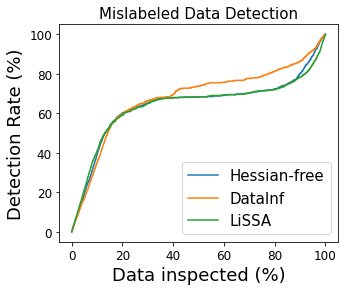

In [10]:
plt.figure(figsize=(5,4))
for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(low_quality_to_high_quality)+1):
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)
    plt.plot(100*np.arange(len(low_quality_to_high_quality))/n_train, 
             detection_rate_list,
             label=method_dict[method])
plt.xlabel('Data inspected (%)', fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.title('Mislabeled Data Detection', fontsize=15)
plt.show()